## Angewandtes Quantencomputing – Laborpraktikum WiSe 25/26

### Musterlösung zu Praktikum 6: Grover auf Quantenhardware (14.11.2025)

In diesem Praktikum werden wir zum ersten Mal einen echten Quantencomputer verwenden.  
Als Beispiel nutzen wir den Grover-Algorithmus aus dem vorherigen Praktikum und führen ihn auf einem kostenlosen System von **IBM Quantum** aus.

Um einen Quantenschaltkreis auf der IBM Quantum Cloud auszuführen, benötigen Sie einen Account.  
Sie können sich dafür kostenlos unter <https://quantum.cloud.ibm.com/signin> registrieren und erhalten anschließend 10 Minuten kostenlose Rechenzeit.

Falls Sie keinen eigenen Account anlegen möchten, sprechen Sie mich bitte an. Für die Praktikumseinheit kann ich Ihnen einen Zugriffstoken zur IBM Quantum Cloud bereitstellen.

### Aufgabe 1: Implementieren des Grover-Algorithmus

Als erste Übung schreiben wir zwei Python-Funktionen, die einen Schaltkreis für den Grover-Algorithmus generieren.  
Die Anzahl der Qubits sowie die Anzahl der Grover-Schritte sollen dabei frei wählbar sein.  

Wir orientieren uns am Beispiel aus dem letzten Praktikum und suchen den Zustand, in dem alle Qubits im $\ket{1}$-Zustand sind.

Die Routinen zur Erzeugung der gleichverteilten Superposition (`initial_state`) sowie zur Amplitudenverstärkung (`amplitude_amplification`) übernehmen wir unverändert aus dem vorherigen Praktikum.  
Wie zuvor können diese Bausteine mithilfe der `compose`-Funktion zusammengefügt werden.

In dieser Aufgabe sollen zwei Varianten des Orakels implementiert werden:
- eine Version ohne Ancilla-Qubit
- eine Version mit Ancilla-Qubit

Für beide Ansätze benötigen wir im Orakel erneut das mehrfach kontrollierte X-Gatter (`mcx`).  
Auf die finalen Messungen verzichten wir an dieser Stelle zunächst.

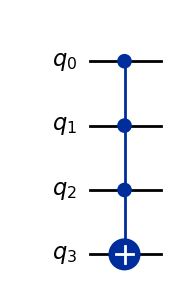

In [1]:
from qiskit import QuantumCircuit
from qc_lecture_tools.grover import (
    initial_state,
    amplitude_amplification,
    print_grover_states,
)

quantum_circuit = QuantumCircuit(4)
quantum_circuit.mcx([0, 1, 2], 3)
quantum_circuit.draw("mpl")

In [2]:
# Beispiel für die Compose Funktion
quantum_circuit1 = QuantumCircuit(1)
quantum_circuit2 = QuantumCircuit(1)
quantum_circuit1.compose(quantum_circuit2, inplace=True)

**Aufgabe 1.1:** Implementierung des Grover-Algorithmus *ohne* Ancilla-Qubits für eine beliebige Anzahl von Qubits und Grover-Schritten.

Nutzen Sie die bereits vorhandenen Routinen für den Anfangszustand sowie für die Amplitudenverstärkung.  
Das Orakel ohne zusätzliches Ancilla-Qubit kann mithilfe eines mehrfach-kontrollierten Z-Gatters umgesetzt werden.  
Da ein solches Gatter in Qiskit nicht direkt existiert, verwenden wir den folgenden Trick: $Z = H X H$

Durch Einbetten des mehrfach-kontrollierten X-Gatters zwischen zwei Hadamard-Gatter auf dem Zielqubit kann somit ein kontrolliertes Z-Gatter realisiert werden.


In [3]:
def grover(num_data_qubits: int, num_steps: int) -> QuantumCircuit:
    """Implementation of the Grover algorithm that finds the |1...11> state

    Args:
        num_data_qubits (int): Number of data qubits
        num_steps (int): Number of Grover-steps

    Returns:
        Quantum circuit of the oracle
    """

    # Create a quantum circuit with the given number of data qubits
    quantum_circuit = QuantumCircuit(num_data_qubits)

    # Prepare the initial uniform superposition (usually |s⟩ state)
    quantum_circuit.compose(initial_state(num_data_qubits, 0), inplace=True)

    # Define the control qubits (all except the last qubit, which acts as target)
    control_qubits = list(range(num_data_qubits - 1))

    # Repeat the Grover iteration (oracle + amplitude amplification)
    for i in range(num_steps):

        # --- Oracle step ---
        # The oracle marks the "solution" state by flipping its phase.
        # Here represented by a controlled multi-qubit X (inversion) gate.
        quantum_circuit.h(num_data_qubits - 1)
        quantum_circuit.mcx(control_qubits, num_data_qubits - 1)
        quantum_circuit.h(num_data_qubits - 1)

        # --- Diffusion (Amplitude amplification) step ---
        # Reflects the state vector about the average amplitude.
        quantum_circuit.compose(
            amplitude_amplification(num_data_qubits, 0), inplace=True
        )

    # Return the constructed Grover circuit
    return quantum_circuit

Sie können den generierten Quantenschaltkreis mit dem folgenden Code visualisieren:

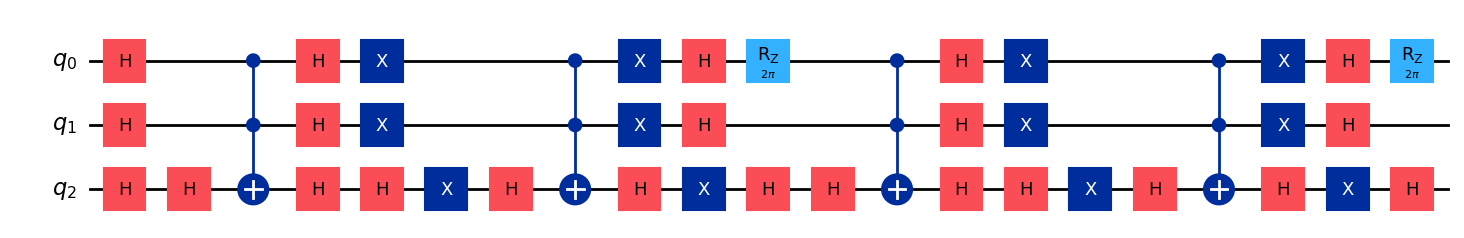

In [4]:
num_data_qubits = 3
num_steps = 2

quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit.draw("mpl")

Testen Sie, ob Ihre Implementierung das erwartete Ergebnis liefert:
Wir nutzten hier wieder die Funktion ``print_grover_states(quantum_circuit, num_data_qubits)`` um den resultierenden Quantenzustand auszugeben. 

In [5]:
num_data_qubits = 3
num_steps = 2

quantum_circuit = grover(num_data_qubits, num_steps)
print_grover_states(quantum_circuit, num_data_qubits)

Gefundene Basiszustände mit Amplituden ungleich Null:
000: -0.09  Wahrscheinlichkeit:  0.01
001: -0.09  Wahrscheinlichkeit:  0.01
010: -0.09  Wahrscheinlichkeit:  0.01
011: -0.09  Wahrscheinlichkeit:  0.01
100: -0.09  Wahrscheinlichkeit:  0.01
101: -0.09  Wahrscheinlichkeit:  0.01
110: -0.09  Wahrscheinlichkeit:  0.01
111:  0.97  Wahrscheinlichkeit:  0.95


**Aufgabe 1.2:** Implementieren Sie den Grover-Algorithmus nun mit einem zusätzlichen Ancilla-Qubit.

In diesem Ansatz verwenden wir ein Ancilla-Qubit, um zwischenzeitlich zu speichern, ob sich alle Daten-Qubits im $\ket{1}$-Zustand befinden (Compute-Schritt).  
Anschließend wird mithilfe eines Z-Gatters das Vorzeichen der Amplitude dieses Zustands geändert.  
Zum Schluss wird im Uncompute-Schritt das Ancilla-Qubit wieder in den $\ket{0}$-Zustand zurückgeführt, sodass keine zusätzliche Verschlaufung im System verbleibt.


In [6]:
def grover_ancilla(num_data_qubits, num_steps):
    """Implementation of the Grover algorithm that finds the |1...11> state using an Ancilla-Qubit

    Args:
        num_data_qubits (int): Number of data qubits
        num_steps (int): Number of Grover-steps

    Returns:
        Quantum circuit of the oracle
    """

    # Create a quantum circuit with one extra ancilla qubit
    quantum_circuit = QuantumCircuit(num_data_qubits + 1)

    # Prepare the initial state, e.g., uniform superposition of all data qubits
    # and the ancilla initialized to |1⟩ (controlled oracle requires ancilla)
    quantum_circuit.compose(initial_state(num_data_qubits, 1), inplace=True)

    # Define the control qubits (all data qubits)
    control_qubits = list(range(num_data_qubits))

    # Perform the specified number of Grover iterations
    for i in range(num_steps):

        # --- Oracle step ---
        # Flip the phase of the |11...1> state using the ancilla qubit.
        # The sequence mcx -> z -> mcx implements a conditional phase inversion.
        quantum_circuit.mcx(control_qubits, num_data_qubits)  # Controlled-X on ancilla
        quantum_circuit.z(num_data_qubits)  # Phase flip on ancilla
        quantum_circuit.mcx(control_qubits, num_data_qubits)  # Undo the controlled-X

        # --- Diffusion (Amplitude amplification) step ---
        # Reflects the state about the mean amplitude to amplify the marked state.
        quantum_circuit.compose(
            amplitude_amplification(num_data_qubits, 1), inplace=True
        )

    # Return the constructed Grover circuit with ancilla
    return quantum_circuit

Sie können den generierten Quantenschaltkreis mit dem folgenden Code visualisieren:


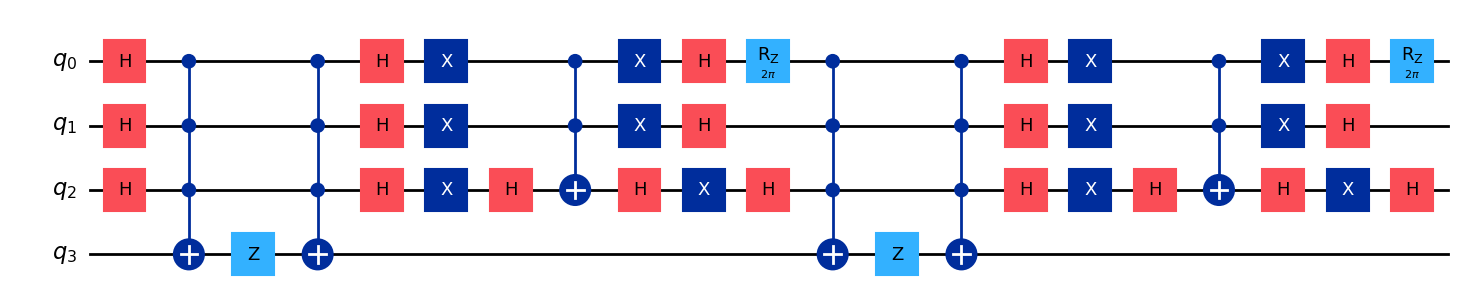

In [7]:
num_data_qubits = 3
num_steps = 2

quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
quantum_circuit.draw("mpl")

Testen Sie, ob Ihre Implementierung das erwartete Ergebnis liefert:

In [8]:
num_data_qubits = 3
num_steps = 2

quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
print_grover_states(quantum_circuit, num_data_qubits)

Gefundene Basiszustände mit Amplituden ungleich Null:
000 0: -0.09  Wahrscheinlichkeit:  0.01
001 0: -0.09  Wahrscheinlichkeit:  0.01
010 0: -0.09  Wahrscheinlichkeit:  0.01
011 0: -0.09  Wahrscheinlichkeit:  0.01
100 0: -0.09  Wahrscheinlichkeit:  0.01
101 0: -0.09  Wahrscheinlichkeit:  0.01
110 0: -0.09  Wahrscheinlichkeit:  0.01
111 0:  0.97  Wahrscheinlichkeit:  0.95


**Aufgabe 1.3:** Finden Sie für 4 und 5 Datenqubits die jeweils geeignete Anzahl von Grover-Schritten, um die Wahrscheinlichkeit für den gesuchten Zustand zu maximieren.

In [9]:
num_data_qubits = 4
num_steps = 3
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
print_grover_states(quantum_circuit, num_data_qubits)

Gefundene Basiszustände mit Amplituden ungleich Null:
0000 0: -0.05  Wahrscheinlichkeit:  0.00
0001 0: -0.05  Wahrscheinlichkeit:  0.00
0010 0: -0.05  Wahrscheinlichkeit:  0.00
0011 0: -0.05  Wahrscheinlichkeit:  0.00
0100 0: -0.05  Wahrscheinlichkeit:  0.00
0101 0: -0.05  Wahrscheinlichkeit:  0.00
0110 0: -0.05  Wahrscheinlichkeit:  0.00
0111 0: -0.05  Wahrscheinlichkeit:  0.00
1000 0: -0.05  Wahrscheinlichkeit:  0.00
1001 0: -0.05  Wahrscheinlichkeit:  0.00
1010 0: -0.05  Wahrscheinlichkeit:  0.00
1011 0: -0.05  Wahrscheinlichkeit:  0.00
1100 0: -0.05  Wahrscheinlichkeit:  0.00
1101 0: -0.05  Wahrscheinlichkeit:  0.00
1110 0: -0.05  Wahrscheinlichkeit:  0.00
1111 0:  0.98  Wahrscheinlichkeit:  0.96


In [10]:
num_data_qubits = 5
num_steps = 4
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
print_grover_states(quantum_circuit, num_data_qubits)

Gefundene Basiszustände mit Amplituden ungleich Null:
00000 0: -0.01  Wahrscheinlichkeit:  0.00
00001 0: -0.01  Wahrscheinlichkeit:  0.00
00010 0: -0.01  Wahrscheinlichkeit:  0.00
00011 0: -0.01  Wahrscheinlichkeit:  0.00
00100 0: -0.01  Wahrscheinlichkeit:  0.00
00101 0: -0.01  Wahrscheinlichkeit:  0.00
00110 0: -0.01  Wahrscheinlichkeit:  0.00
00111 0: -0.01  Wahrscheinlichkeit:  0.00
01000 0: -0.01  Wahrscheinlichkeit:  0.00
01001 0: -0.01  Wahrscheinlichkeit:  0.00
01010 0: -0.01  Wahrscheinlichkeit:  0.00
01011 0: -0.01  Wahrscheinlichkeit:  0.00
01100 0: -0.01  Wahrscheinlichkeit:  0.00
01101 0: -0.01  Wahrscheinlichkeit:  0.00
01110 0: -0.01  Wahrscheinlichkeit:  0.00
01111 0: -0.01  Wahrscheinlichkeit:  0.00
10000 0: -0.01  Wahrscheinlichkeit:  0.00
10001 0: -0.01  Wahrscheinlichkeit:  0.00
10010 0: -0.01  Wahrscheinlichkeit:  0.00
10011 0: -0.01  Wahrscheinlichkeit:  0.00
10100 0: -0.01  Wahrscheinlichkeit:  0.00
10101 0: -0.01  Wahrscheinlichkeit:  0.00
10110 0: -0.01  Wahrsc

## Aufgabe 2: Optionale Registrierung bei IBM Quantum

Gehen Sie dazu auf <https://quantum.cloud.ibm.com/signin> und klicken Sie oben links auf **"Create an IBM Cloud account"**.

Folgen Sie den Schritten, um ein Konto für die IBM Cloud zu erstellen.

Falls Sie im Registrierungsprozess versehentlich auf der allgemeinen IBM Cloud statt auf der IBM Quantum Cloud landen, rufen Sie einfach erneut <https://quantum.cloud.ibm.com/> auf, um wieder zur Quantum-Plattform zu gelangen.

Sobald Sie in der IBM Quantum Cloud eingeloggt sind, klicken Sie oben links auf **"API key"** und anschließend auf **"Create"**.  
Geben Sie einen Namen für den API-Key ein und bestätigen Sie mit **Create**.

Klicken Sie anschließend auf **Copy** und speichern Sie den API-Key an einem sicheren Ort ab — wir werden ihn im Verlauf dieses Notebooks noch benötigen.

Falls die Registrierung nicht funktioniert oder Sie sich nicht registrieren möchten, sprechen Sie mich bitte an.  
Ich kann Ihnen für diese Praktikumseinheit einen API-Key zur Verfügung stellen.

## Aufgabe 3: Aufbau der Verbindung zu IBM Quantum

Wenn Sie nun einen API-Key zur Hand haben, können wir eine Verbindung zur IBM Quantum Cloud aufbauen und uns die verfügbaren Quantencomputer anzeigen lassen.  
Im Anschluss untersuchen wir die verschiedenen verfügbaren Backends.

**Aufgabe 3.1:** Aufbau der Verbindung zur IBM Quantum Cloud

Um eine Verbindung zur IBM Quantum Cloud herzustellen, verwenden wir die Funktion `QiskitRuntimeService`.  
Dieser Funktion müssen wir unseren API-Key übergeben, damit die Authentifizierung und der Zugriff auf die verfügbaren Ressourcen möglich ist.  
Die Funktion gibt ein Objekt zurück, über das anschließend auf die Hardware-Backends zugegriffen werden kann.

Fügen Sie Ihren API-Key in den folgenden Code ein und lassen Sie sich alle verfügbaren Backends anzeigen.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Verbinden mit der IBM Quantum Cloud
service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN HIER EINFÜGEN")
service.backends()

qiskit_runtime_service._discover_account:WARNING:2025-11-14 11:15:24,858: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-14 11:15:27,495: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: HHN. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-14 11:15:27,496: Loading instance: HHN, plan: open


[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

**Aufgabe 3.2:** Verwendung eines spezifischen Quantum-Backends

Um ein bestimmtes Quantum-Backend zu nutzen, kann ein Backend-Objekt mit der Funktion `service.backend()` erzeugt werden.  
Dabei muss der Name des gewünschten Backends übergeben werden. Beispiel:

```python
backend_torino = service.backend('ibm_torino')
```

Untersuchen Sie anschließend:

* die Anzahl der Qubits des Backends (abrufbar über ``backend.num_qubits``)
* die auf der Hardware verfügbaren Quantengatter (abrufbar über ``backend.operation_names``)

Vergleichen Sie die für Ihre Implementierung des Grover-Algorithmus benötigten Quantengatter mit den auf der Hardware verfügbaren Gattern.

In [12]:
# Initialisierung des echten Backends ibm_torino und Ausgabe der Qubits und nativen Gatter
backend_torino = service.backend("ibm_torino")
print("Anzahl von Qubits:", backend_torino.num_qubits)
print("Quantengatter:", backend_torino.operation_names)

qiskit_runtime_service.backends:WARNING:2025-11-14 11:15:28,265: Using instance: HHN, plan: open


Anzahl von Qubits: 133
Quantengatter: ['x', 'id', 'measure', 'reset', 'sx', 'rz', 'if_else', 'delay', 'cz']


**Beobachtung:** Die nativen Quantengatter sind andere als in dem Quantenschaltkreis

**Aufgabe 3.3:** Um den Softwarezugang zur Hardware zu testen, benutzen wir zunächst einen simulierten Quantencomputer. Dieser besitzt das gleiche Software-Interface wie die echte Hardware, verbraucht aber keine Rechenzeit.

Im folgenden Code wird das Backend `FakeManilaV2` initialisiert.  
Finden Sie auch hier die Anzahl der Qubits und die möglichen Quantengatter heraus.

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend_fake_manila = FakeManilaV2()

In [14]:
print(backend_fake_manila.num_qubits)
print(backend_fake_manila.operation_names)

5
['x', 'id', 'measure', 'reset', 'rz', 'sx', 'if_else', 'switch_case', 'delay', 'for_loop', 'cx']


### Aufgabe 4: Transpilieren

Wir haben in Aufgabe 3 gesehen, dass ein Quantencomputer nur eine bestimmte Menge an Quantengattern zur Verfügung stellt. Einige dieser Gatter (z. B. `sx`, also $\sqrt{X}$ – die Wurzel des X-Gatters) wurden in der Vorlesung nicht behandelt.

Wichtig ist, dass jeder Quantencomputer eine universelle Menge an Quantengattern bereitstellt (universal Gateset). Das bedeutet, dass sich *jedes* Quantengatter als Kombination dieser nativen Gatter darstellen lässt.

Wenn wir einen Schaltkreis auf echter Hardware ausführen möchten, müssen wir ihn zunächst in die nativen Gatter des jeweiligen Quantencomputers übersetzen.  
Dieser Prozess heißt **Transpilieren** und ist essenziell, um zwischen verschiedenen Gattersets wechseln zu können.

Neben der Umwandlung zwischen verschiedenen Gattern optimiert die Transpilierung den Schaltkreis zusätzlich:  
- redundante Gatter (z. B. $XX = I$) werden entfernt  
- Gatter werden, falls möglich, vertauscht, ohne den Zustand zu verändern  
- es wird bestimmt, auf welchen physischen Qubits der Hardware der Schaltkreis ausgeführt wird – unter Berücksichtigung der individuellen Fehlerraten  

Im Grunde ist die Transpilierung im Quantencomputing vergleichbar mit der Kompilierung auf einem klassischen Computer.

In Qiskit gibt es dafür die Funktion `transpile`.  
Sie erhält ein Backend und einen Quantenschaltkreis und gibt den transpilierten Schaltkreis zurück.


In [15]:
from qiskit.compiler import transpile

quantum_circuit1 = QuantumCircuit(1)
backend_manila = FakeManilaV2()

transpiled_circuit = transpile(quantum_circuit1, backend=backend_manila)

**Aufgabe 4.1:** Transpilieren Sie den Schaltkreis Ihrer Grover-Implementierung für 3 Datenqubits und einen Grover-Schritt und vergleichen Sie ihn mit dem ursprünglichen Schaltkreis.  
Führen Sie die Transpilierung einmal mit dem simulierten Backend (`FakeManilaV2()`) und einmal mit dem echten IBM-Backend (`service.backend('ibm_torino')`) durch.

Visualisieren Sie die Quantengatter mit der Funktion `quantum_circuit.draw('mpl')` und untersuchen Sie die Anzahl der einzelnen Quantengatter in den Schaltkreisen für alle drei Fälle.

**Hinweis:** Für Quantenschaltkreise existiert eine Funktion zum Zählen der Quantengatter:  
`quantum_circuit.count_ops()`

OrderedDict([('h', 13), ('x', 6), ('ccx', 2), ('rz', 1)])


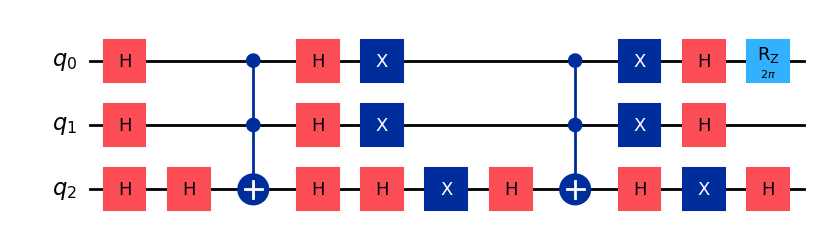

In [16]:
# Originaler Grover Schaltkreis
num_data_qubits = 3
num_steps = 1
quantum_circuit = grover(num_data_qubits, num_steps)

print(quantum_circuit.count_ops())
quantum_circuit.draw("mpl")

OrderedDict([('rz', 32), ('sx', 17), ('cx', 17)])


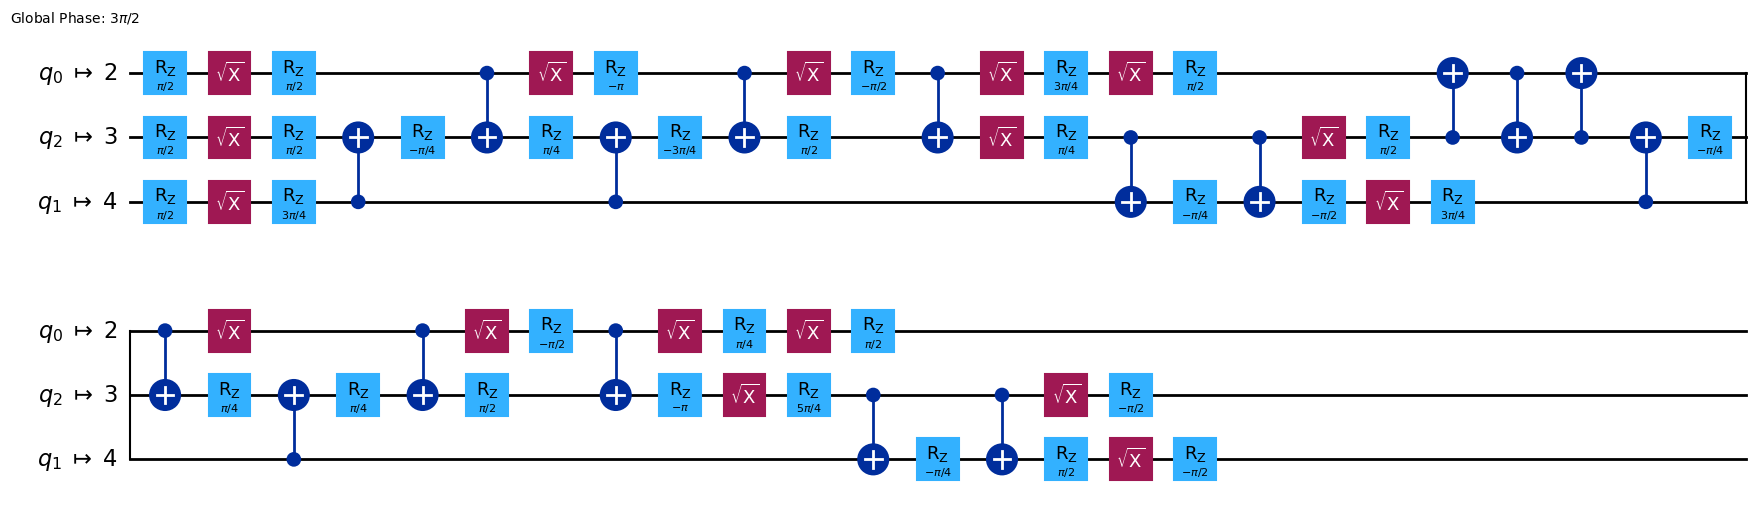

In [17]:
# Transpilierung und Ausgabe für das Simulierte Backend
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)
print(quantum_circuit_transpiled.count_ops())
quantum_circuit_transpiled.draw("mpl")

OrderedDict([('sx', 38), ('rz', 37), ('cz', 17), ('x', 1)])


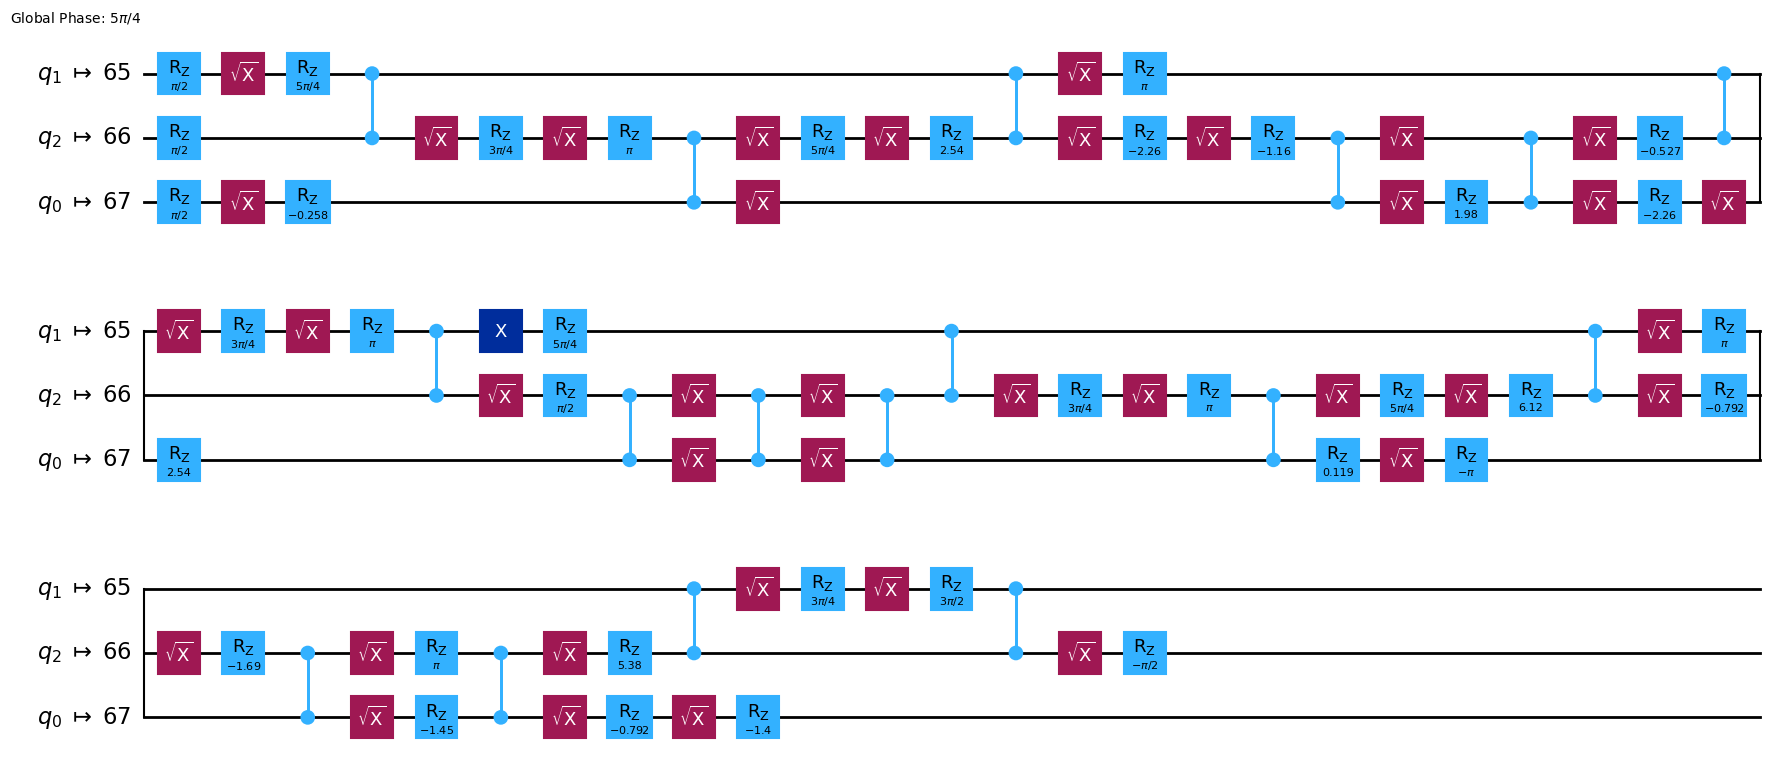

In [18]:
# Transpilierung und Ausgabe für das echte Backend ibm_torino
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)
print(quantum_circuit_transpiled.count_ops())
quantum_circuit_transpiled.draw("mpl")

**Aufgabe 4.2:** Wiederholen Sie Aufgabe 4.1 für den Schaltkreis mit dem zusätzlichen Ancilla-Qubit (3 Datenqubits und 1 Grover-Schritt).  
Vergleichen Sie anschließend die Anzahl der 2-Qubit-Gatter (`cx` und `cz`) mit dem Fall ohne Ancilla-Qubit.

OrderedDict([('h', 11), ('x', 6), ('mcx', 2), ('z', 1), ('ccx', 1), ('rz', 1)])


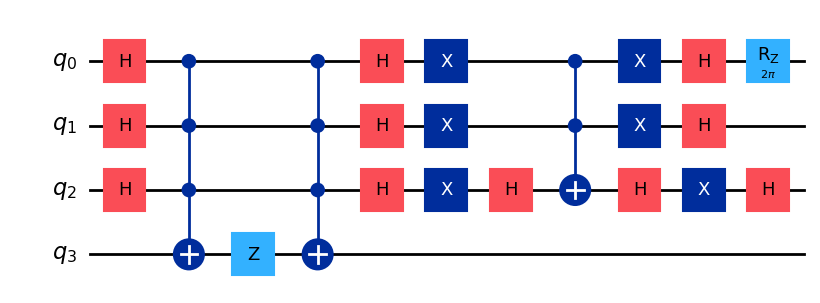

In [19]:
# Originaler Grover Schaltkreis
num_data_qubits = 3
num_steps = 1
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
print(quantum_circuit.count_ops())
quantum_circuit.draw("mpl")

OrderedDict([('rz', 82), ('cx', 59), ('sx', 44), ('x', 3)])


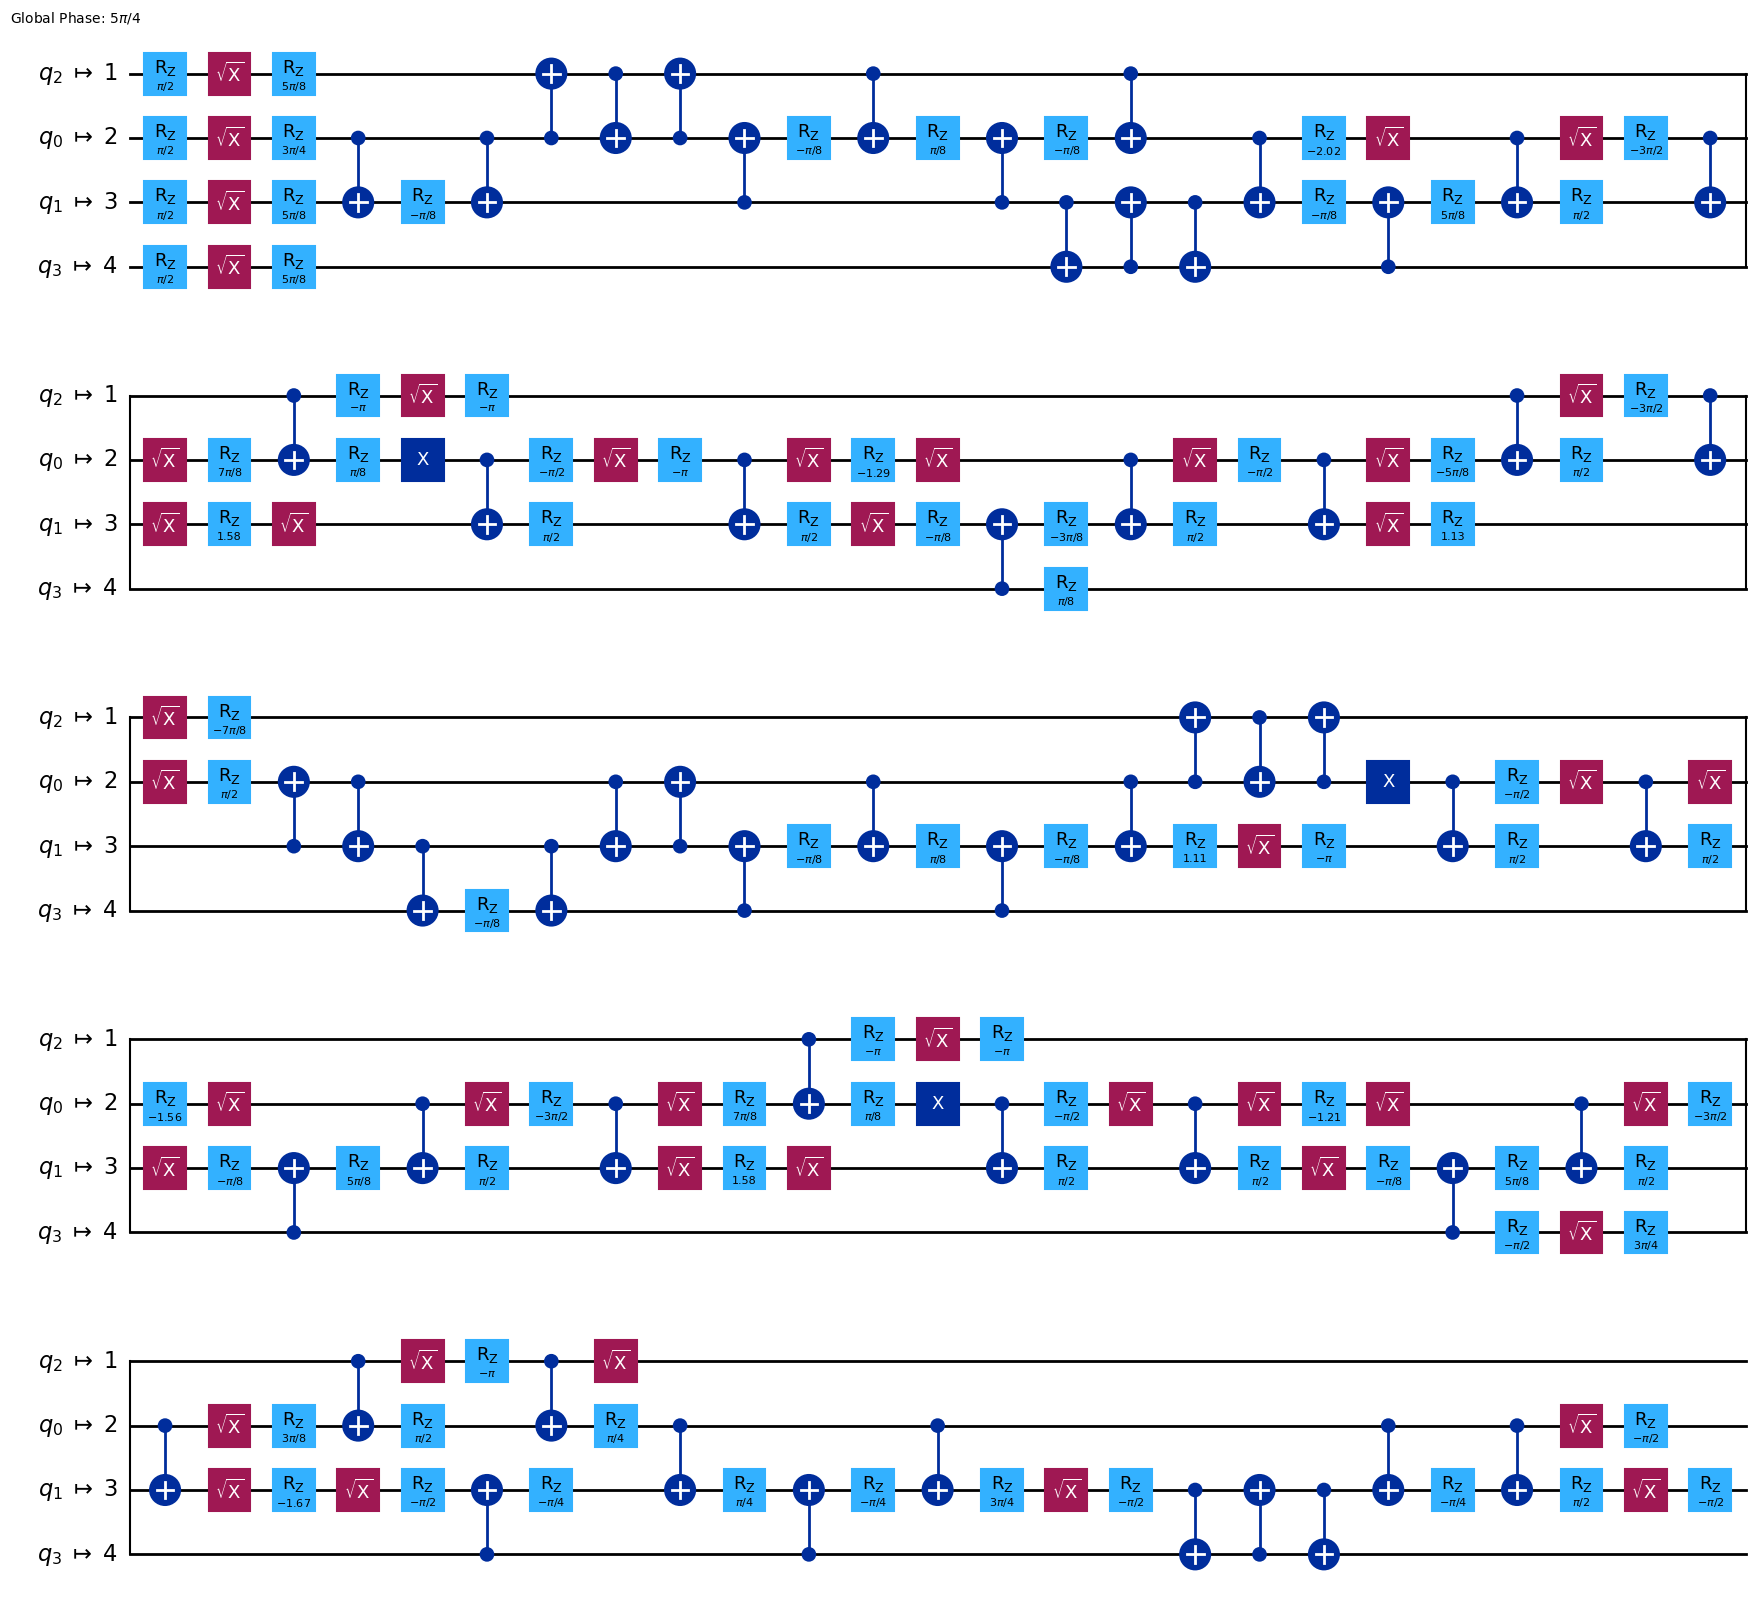

In [20]:
# Transpilierung und Ausgabe für das Simulierte Backend
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)
print(quantum_circuit_transpiled.count_ops())
quantum_circuit_transpiled.draw("mpl")

OrderedDict([('sx', 104), ('rz', 77), ('cz', 47), ('x', 3)])


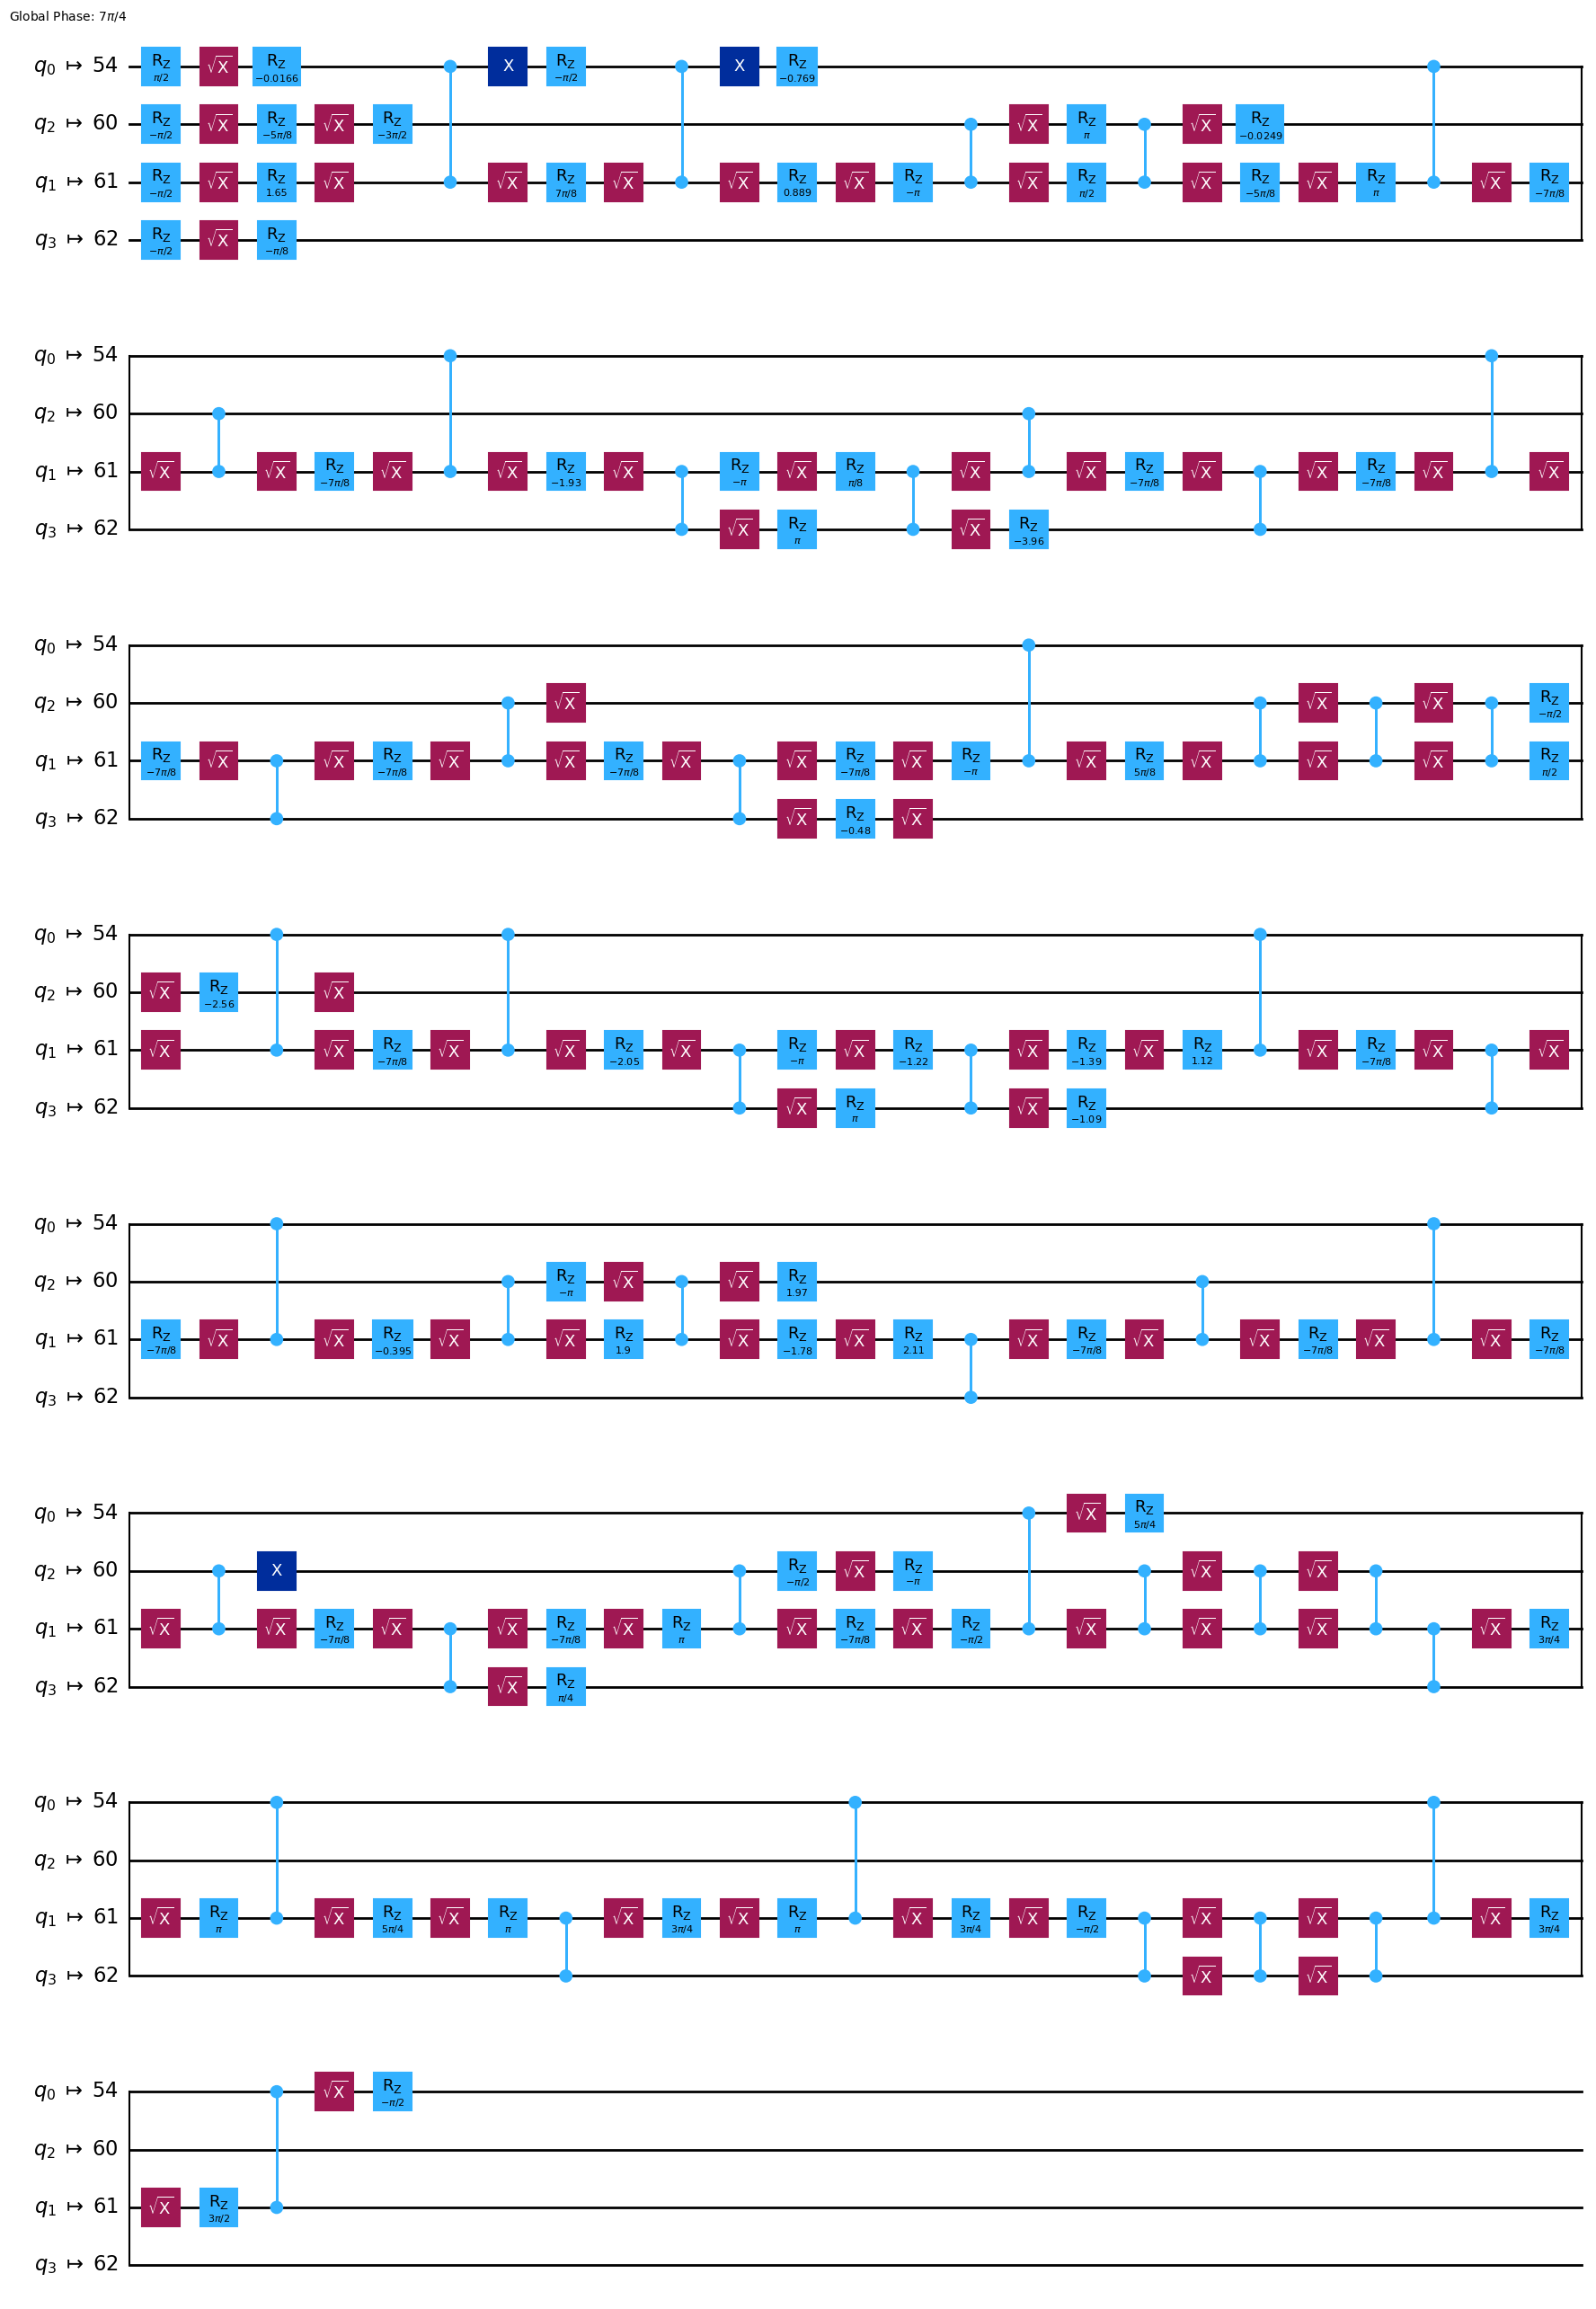

In [21]:
# Transpilierung und Ausgabe für das echte Backend ibm_torino
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)
print(quantum_circuit_transpiled.count_ops())
quantum_circuit_transpiled.draw("mpl")

### Aufgabe 5: Ausführen mit simulierter Hardware

Nun sind alle Zwischenschritte vorhanden, um die Grover-Schaltkreise später auf echter Hardware auszuführen.  
In diesem Abschnitt verwenden wir keine eigenen Hilfsfunktionen mehr, sondern nutzen direkt Qiskit für die Ausführung und das Sampeln der Quantenschaltkreise.  

Zum Üben führen wir zunächst alle Experimente mit einem Simulator aus, um sicherzustellen, dass alles wie erwartet funktioniert.  
Sie müssen hier nicht viel selbst implementieren, sondern können den gegebenen Code mehrfach wiederverwenden und anpassen.

**Achtung:** In Qiskit ist die Nummerierung der Bits in den Basiszuständen anders als bisher.  
Das erste Qubit steht im Bitstring **rechts**:  $\ket{q_n \ldots q_3 q_2 q_1}$.

Damit dies wieder mit unserer bisherigen Nummerierung übereinstimmt, können wir vor der Messung die Funktion  `quantum_circuit.reverse_bits()`  aufrufen, um die Reihenfolge der Qubits umzukehren.

Der folgende Code implementiert das Sampeln des Schaltkreises für den Bell-State auf der Quantenhardware und gibt das Ergebnis als Python-Dictionary zurück.

Um Ihren Zugang zu testen, können Sie das simulierte Backend auch durch ein echtes IBM-Backend ersetzen.

In [22]:
# Beispiel Code für das Messen des Bell-Zustandes auf der Quantenhardware

from qiskit_ibm_runtime import SamplerV2

# Bell-State
quantum_circuit = QuantumCircuit(2)
quantum_circuit.h(0)
quantum_circuit.cx(0, 1)

# Umkehr der Reihenfolge der Qubits:
quantum_circuit = quantum_circuit.reverse_bits()

# Finale Messung hinzufügen
quantum_circuit.measure_all()

# Transpilierung des Schaltkreises
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)

# Anzahl der Messungen
num_shots = 100

# Initialisierung des Sampler Primitives in Qiskit, um auf der Hardware die Messungen auszuführen.
# Bei mode= wird das Backend festgelegt.
sampler = SamplerV2(mode=backend_fake_manila, options={"default_shots": num_shots})

# In Qiskit werden die Schaltkreise in einer Liste übergeben, um das Ausführen von mehreren Schalkreisen
# auf einemal zu unterstützen. Hier nehmen wir einfach nur eine Liste von einem Schaltkreis
pubs = [quantum_circuit_transpiled]

# Mit diesem Aufruf senden wir unseren Schaltkreis (unsere Schaltkreise an Qiskit)
# Die Schaltkreise werden in die Queue von IBM eingereiht bis sie ausgeführt werden.
job = sampler.run(pubs)

# Die Funktion job.result() wartet, bis das Ergebnis vorliegt.
# Die wir den Schaltkreis als Liste übergeben müssen, bekommen wir auch das Ergebnis als Liste.
# Wir nehemen das erste element der Luste um an unser Ergebniss zu kommen
result = job.result()[0]

# Um an die Anzahl der Messugen zu kommen, nutzen wir die folgende Funktion:
result.data.meas.get_counts()

{'00': 57, '11': 41, '01': 1, '10': 1}

Sie können den Code von oben nun wiederverwenden und jeweils nur das Backend und den Quantenschaltkreis anpassen.

**Aufgabe 5.1:** Testen Sie zunächst Ihre Grover-Implementierung ohne Ancilla-Qubits für 3 Datenqubits und 2 Grover-Schritte mit dem Simulator.

In [23]:
num_data_qubits = 3
num_steps = 2
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)

num_shots = 100
sampler = SamplerV2(mode=backend_fake_manila, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'111': 55,
 '110': 16,
 '010': 4,
 '100': 6,
 '001': 2,
 '011': 10,
 '101': 5,
 '000': 2}

**Aufgabe 5.2:** Wiederholen Sie Aufgabe 5.1 für Ihre Grover-Implementierung **mit Ancilla-Qubit** für 3 Datenqubits und 2 Grover-Schritte auf dem Simulator.  
Was beobachten Sie im Vergleich zur Implementierung ohne Ancilla-Qubit?

In [24]:
num_data_qubits = 3
num_steps = 2
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)

num_shots = 100
sampler = SamplerV2(mode=backend_fake_manila, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'0110': 7,
 '1111': 5,
 '1110': 22,
 '0011': 5,
 '0101': 5,
 '1100': 7,
 '1010': 5,
 '0000': 6,
 '0010': 5,
 '1101': 7,
 '1011': 2,
 '1000': 5,
 '0001': 1,
 '0111': 9,
 '0100': 6,
 '1001': 3}

**Aufgabe 5.3:** Untersuchen Sie, ob Sie mit dem Simulator und **ohne** Ancilla-Qubit für 4 Datenqubits und 2 Grover-Schritte noch gute Ergebnisse erhalten.

In [25]:
num_data_qubits = 4
num_steps = 2
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)

num_shots = 100
sampler = SamplerV2(mode=backend_fake_manila, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'1001': 6,
 '1100': 5,
 '1111': 27,
 '0100': 8,
 '0101': 8,
 '0011': 6,
 '1011': 6,
 '1010': 2,
 '0001': 2,
 '0010': 4,
 '1110': 5,
 '0110': 2,
 '1101': 8,
 '1000': 5,
 '0000': 3,
 '0111': 3}

**Aufgabe 5.4:** Wie sieht das Ergebnis für den Grover-Algorithmus **mit Ancilla-Qubit** bei 4 Datenqubits und 2 Grover-Schritten aus?

In [26]:
num_data_qubits = 4
num_steps = 2
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_fake_manila)

num_shots = 100
sampler = SamplerV2(mode=backend_fake_manila, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'00011': 6,
 '11011': 6,
 '11111': 4,
 '01001': 8,
 '01010': 5,
 '11100': 2,
 '00100': 3,
 '00000': 4,
 '01000': 8,
 '01111': 3,
 '00110': 3,
 '10010': 2,
 '11000': 2,
 '10001': 2,
 '11110': 7,
 '01100': 4,
 '10011': 7,
 '01011': 1,
 '01101': 1,
 '10101': 3,
 '10000': 3,
 '00111': 2,
 '10110': 4,
 '10100': 3,
 '00010': 1,
 '11101': 1,
 '00101': 2,
 '11010': 1,
 '11001': 1,
 '00001': 1}

### Aufgabe 6: Ausführen auf echter Quantenhardware

Nachdem der Grover-Algorithmus auf dem Simulator funktioniert, können wir die Rechnungen nun auf der echten Hardware wiederholen.  
Kopieren Sie dazu einfach den Code von oben und tauschen Sie bei der Initialisierung des Samplers lediglich das Backend aus.

**Aufgabe 6.1:** Führen Sie Ihre Grover-Implementierung **ohne Ancilla-Qubit** mit 3 Datenqubits und 2 Grover-Schritten auf der echten Quantenhardware aus.

In [27]:
num_data_qubits = 3
num_steps = 2
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)

num_shots = 100
sampler = SamplerV2(mode=backend_torino, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'110': 3,
 '111': 80,
 '101': 7,
 '010': 2,
 '011': 3,
 '001': 3,
 '100': 1,
 '000': 1}

**Aufgabe 6.2:** Wiederholen Sie das Ganze für 4 Datenqubits mit 3 Grover-Schritten und für 5 Datenqubits mit 4 Grover-Schritten.  
Was beobachten Sie?

In [28]:
num_data_qubits = 4
num_steps = 3
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)

num_shots = 100
sampler = SamplerV2(mode=backend_torino, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'1010': 3,
 '1111': 38,
 '0010': 3,
 '0100': 4,
 '0101': 3,
 '1001': 2,
 '0000': 5,
 '0110': 5,
 '0111': 8,
 '1101': 5,
 '0001': 3,
 '1110': 8,
 '1000': 6,
 '1100': 3,
 '0011': 1,
 '1011': 3}

In [29]:
num_data_qubits = 5
num_steps = 4
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)

num_shots = 100
sampler = SamplerV2(mode=backend_torino, options={"default_shots": num_shots})

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XX"

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'00000': 4,
 '11010': 4,
 '11100': 3,
 '00011': 6,
 '00010': 4,
 '11110': 5,
 '01101': 5,
 '01010': 6,
 '01001': 4,
 '10001': 2,
 '10000': 2,
 '01000': 3,
 '11011': 7,
 '00001': 2,
 '11001': 3,
 '01011': 3,
 '00110': 2,
 '10101': 2,
 '11111': 6,
 '10010': 1,
 '11101': 1,
 '00111': 3,
 '11000': 5,
 '00101': 2,
 '10110': 2,
 '10011': 4,
 '10100': 4,
 '10111': 2,
 '01110': 1,
 '00100': 1,
 '01100': 1}

In [30]:
num_data_qubits = 6
num_steps = 4
quantum_circuit = grover(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)

print(quantum_circuit_transpiled.count_ops())

num_shots = 100
sampler = SamplerV2(mode=backend_torino, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

OrderedDict([('sx', 2694), ('rz', 1811), ('cz', 1263), ('x', 47), ('measure', 6), ('barrier', 1)])


{'110111': 1,
 '000110': 2,
 '000001': 3,
 '110011': 3,
 '011000': 2,
 '110001': 2,
 '010100': 1,
 '001000': 6,
 '101101': 3,
 '101110': 3,
 '010111': 3,
 '100100': 1,
 '110101': 3,
 '100000': 3,
 '001101': 3,
 '010010': 2,
 '000010': 3,
 '011111': 1,
 '001010': 2,
 '011011': 1,
 '001111': 1,
 '110100': 1,
 '010000': 2,
 '101010': 2,
 '100101': 3,
 '101011': 4,
 '000101': 6,
 '110010': 1,
 '011010': 1,
 '010110': 2,
 '100011': 1,
 '111101': 1,
 '000000': 2,
 '000100': 1,
 '100111': 2,
 '101001': 2,
 '011101': 1,
 '010001': 1,
 '001100': 1,
 '001011': 1,
 '111000': 1,
 '111011': 1,
 '011110': 2,
 '000011': 2,
 '100110': 1,
 '111010': 1,
 '111100': 2,
 '100010': 1,
 '101000': 3,
 '111111': 1,
 '101100': 1}

**Aufgabe 6.3:** Lassen Sie nun die Grover-Variante **mit Ancilla-Qubit** für 4 Datenqubits und 3 Grover-Schritte auf der Hardware laufen.

In [31]:
num_data_qubits = 4
num_steps = 3
quantum_circuit = grover_ancilla(num_data_qubits, num_steps)
quantum_circuit = quantum_circuit.reverse_bits()
quantum_circuit.measure_all()
quantum_circuit_transpiled = transpile(quantum_circuit, backend=backend_torino)

num_shots = 100
sampler = SamplerV2(mode=backend_torino, options={"default_shots": num_shots})

pubs = [quantum_circuit_transpiled]
job = sampler.run(pubs)
result = job.result()[0]

result.data.meas.get_counts()

{'00010': 6,
 '00000': 6,
 '11110': 9,
 '01010': 5,
 '10000': 6,
 '00110': 3,
 '11100': 5,
 '11011': 1,
 '00100': 11,
 '00001': 1,
 '00011': 1,
 '01110': 4,
 '11000': 3,
 '10001': 2,
 '01000': 6,
 '01100': 4,
 '00101': 3,
 '00111': 2,
 '01011': 1,
 '11010': 5,
 '10111': 2,
 '10010': 1,
 '10101': 3,
 '10011': 5,
 '10100': 1,
 '11101': 1,
 '11111': 2,
 '01101': 1}